In [1]:
import nltk
import os
import re
import math
import pandas as pd
import numpy as np
import copy
import string
import random
import itertools
import time
import csv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import axes3d, Axes3D
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [2]:
%matplotlib notebook

Time to pre-process69.0


<IPython.core.display.Javascript object>


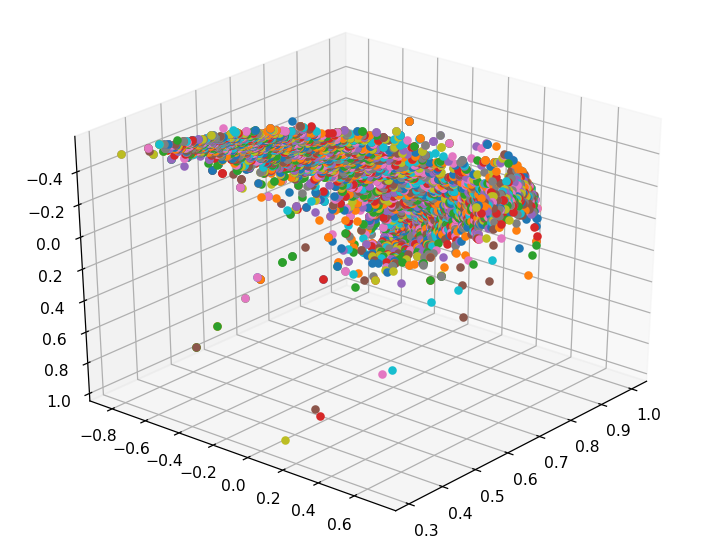

[[ 0.68375065 -0.70987285 -0.16901356]
 [ 0.55076294 -0.75702806 -0.3515234 ]
 [ 0.72713549 -0.67077946 -0.14604417]
 ...
 [ 0.92954716 -0.15401199  0.3349961 ]
 [ 0.68925288 -0.652783   -0.31433234]
 [ 0.80581347  0.52891044 -0.2663051 ]]


In [3]:
all_texts=[]
Y = []
start = time.process_time()
# os.chdir("C://Users//Hp//Desktop//Projects//Text-Mining//bbcsport")
os.chdir("C://Users//Hp//Desktop//Projects//Text-Mining//20NewsGroup-2")
directories = os.listdir()
label = 0
for directory in directories:
    path = os.path.join(os.getcwd(),directory)
    os.chdir(path)
    files = os.listdir()
    temp = []
    for file in files:
        with open(file,'r') as curr_file:
            all_texts.append(curr_file.read())
            Y.append(label)
    label = label + 1
    os.chdir('..')
os.chdir('..')
path = os.path.join(os.getcwd(),"GWO")
os.chdir(path)
tfidf = TfidfVectorizer(all_texts, stop_words='english')
vectors = tfidf.fit_transform(all_texts)
all_words = tfidf.get_feature_names()
vectors_dense = vectors.todense()
svd = TruncatedSVD(n_components=3)
vectors_dense_svd = svd.fit_transform(vectors_dense)
vectors_dense_svd = Normalizer().fit_transform(vectors_dense_svd)
end = time.process_time()
print("Time to pre-process"+str(end-start))
fig=plt.figure()
X = vectors_dense_svd
random.shuffle(X)
ax = Axes3D(fig)
print(X)
for j in range(len(X)):
    ax.scatter(X[j][0], X[j][1], X[j][2], marker='o')
    ax.view_init(330, 140)
plt.show()

In [4]:
max_iter = 100 #Maximum number of iterations
N = 12         #Population size (In the range 5 to 12)
K = 5         #Number of clusters

In [5]:
def population_initialization():
    '''
    Parameters:
    Output:
        N wolves of length K*D where D is the number of features
    Function:
        Takes K random datapoints from the dataset and appends them to create a chromosome
        This is repeated N times
    '''
    wolves_pack=[]
    for i in range(N):
        wolf=[]
        for j in range(K):
            wolf.append(X[random.randint(0,len(X)-1)])
        wolf=list(itertools.chain(*wolf))
        wolves_pack.append(wolf)
    return wolves_pack

In [6]:
#Function to decide cluster using Euclidean distance
def cosine_similarity(centers,datapoint):
    '''
    Parameters:
        centers: List of Cluster centers
        K : number of clusters
        datapoint : Datapoint
    Output:
        Cluster number alloted based on maximum cosine_similarity of the datapoint with the cluster centers
    '''
    #Cosine Similarity    
    t = np.asarray(datapoint)
    normt= np.linalg.norm(t)
    dot=[]
    for i in range(K):
        temp_center = np.asarray(centers[i])
        normc = np.linalg.norm(temp_center)
        cos_sim_value=np.dot(t,temp_center)/(normt*normc)
        dot.append(cos_sim_value)
    
    return dot.index(max(dot))

In [7]:
def euclidean_dist_based_center_decision(centers,datapoint):
    t = np.asarray(datapoint)
    dist=[]
    for i in range(K):
        temp_center = np.asarray(centers[i])
        dist.append(np.sqrt(np.sum(np.square(temp_center-t))))
    return dist.index(min(dist))

In [8]:
def fitness_function(wolf):
    '''
    Input : wolf -> A 1 x d(number of documents) vector containing the initial population
    Output: theta -> Fitness value of each wolf
    '''
    centers=[]
    
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
    
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
        clusters[cosine_similarity(centers,X[i])].append(X[i])
        
    n_components=2
    svd = TruncatedSVD(n_components)
    U  = []
    for i in range(K):
        if(len(clusters[i])!=0):
            U.append(svd.fit_transform(clusters[i]))
    
    theta=0
    for i in range(n_components):
        for j in range(len(U)):
            for k in range(len(U)):
                if k!=j and (U[k].shape)[1]==(U[j].shape)[1]:
                    t1 = U[j][:,i]
                    t2 = U[k][:,i]
                    diff = abs(t2.shape[0]-t1.shape[0])
                    if t1.shape[0] < t2.shape[0]:
                        t1 = np.append(t1, np.zeros(diff))
                    elif t1.shape[0] > t2.shape[0]:
                        t2 = np.append(t2, np.zeros(diff))
                    temp = np.dot(t1,t2)/(np.linalg.norm(t1)*np.linalg.norm(t2))
                    theta=theta+math.acos(temp)
    
    centers=[]
    for i in range(K):
        temp=clusters[i]
        if len(temp)!=0:
            centers.append((np.sum(np.asarray(temp),axis=0)/len(temp)).tolist())
        else:
            temp_list=X[random.randint(0,len(X)-1)]
            centers.append(temp_list)
    
    wolf =[]
    for i in range(len(centers)):
        wolf.extend(centers[i])
    fitness_score = theta
    return fitness_score,wolf

In [9]:
def fitness_evaluation(wolves):
    '''
    Input: wolves -> A N x d dimension matrix containing wolves
    Output:fitness-> A N x 1 dimension vector containing fitness values of all wolves
    '''
    fitness = []
    new_wolves=[]
    for i in range(len(wolves)):
        fit,wolf = fitness_function(wolves[i])
        fitness.append(fit)
        new_wolves.append(wolf)
    return fitness,new_wolves

In [10]:
def find_beta(wolves, fitness):
    alpha = max(fitness)
    beta  = -1000
    for i in fitness:
        if beta<i and i!=alpha:
            beta = i
    return wolves[fitness.index(beta)]

In [11]:
def find_gamma(wolves,fitness, beta):
    alpha = max(fitness)
    gamma = -10000
    for i in fitness:
        if gamma<i and i!=alpha and i!=beta:
            gamma = i
    return wolves[fitness.index(gamma)]

In [12]:
def grey_wolf_optimization():
    gen_fitness = []
    start = time.process_time()
    wolves = population_initialization()
    fitness,wolves= fitness_evaluation(wolves)
    alpha  = wolves[fitness.index(max(fitness))] 
    beta   = find_beta(wolves, fitness)
    gamma  = find_gamma(wolves, fitness, fitness[wolves.index(beta)])
    
    a = 2
    
    C1 = 2*np.random.random(size = len(alpha))
    C2 = 2*np.random.random(size = len(beta))
    C3 = 2*np.random.random(size = len(gamma))
    
    A1 = 2*a*np.random.random(size = len(alpha)) - a 
    A2 = 2*a*np.random.random(size = len(beta)) - a
    A3 = 2*a*np.random.random(size = len(gamma)) - a
    
    t = 0
    gen_vs_fitness = []
    stop_gwo = False
    while t<max_iter and not stop_gwo:
        for i in wolves:
            if i!=alpha and i!=beta and i!=gamma:
                D_alpha = np.linalg.norm(np.dot(C1,alpha)-i)
                D_beta  = np.linalg.norm(np.dot(C2,beta)-i)
                D_gamma = np.linalg.norm(np.dot(C3,gamma)-i)

                X1 = alpha - A1*D_alpha
                X2 = beta - A2*D_beta
                X3 = gamma - A3*D_gamma

                i = (X1+X2+X3)/3
        #-----------------------------------------------------
        a = 2 - t*(2/max_iter)
        
        C1 = 2*np.random.random(size = len(alpha))
        C2 = 2*np.random.random(size = len(beta))
        C3 = 2*np.random.random(size = len(gamma))

        A1 = 2*a*np.random.random(size = len(alpha)) - a 
        A2 = 2*a*np.random.random(size = len(beta)) - a
        A3 = 2*a*np.random.random(size = len(gamma)) - a
        
        t = t + 1
        
        fitnes, wolves = fitness_evaluation(wolves)
        temp = []
        temp.append(str(t))
        temp.append(str(max(fitnes)))
        gen_fitness.append(temp)
        print("Generation "+ str(t) + ": "+str(max(fitnes)))
        if t>2 and abs(max(fitnes)-gen_vs_fitness[-1])<0.001 and abs(max(fitnes)-gen_vs_fitness[-2])<0.001:
            stop_gwo=True
            print("Stopping GWO because same results over past 2 generations")
        else:
            gen_vs_fitness.append(max(fitnes))
        alpha  = wolves[fitnes.index(max(fitnes))] 
        beta   = find_beta(wolves, fitnes)
        gamma  = find_gamma(wolves, fitnes, fitnes[wolves.index(beta)])
    
    end = time.process_time()
    print("Time taken: " + str(end-start))
    with open('GWO with K='+str(K)+'.csv','w+') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerows(gen_fitness)
    csvFile.close()
    return alpha

In [13]:
def intracluster_distances(wolf):
    centers=[]
    
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
    
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
        clusters[cosine_similarity(centers,X[i])].append(X[i])
   
    intracluster_d=[]
    for i in range(K):
        M=0
        temp=clusters[i]
        center=centers[i]
        for j in temp:
            M+=np.linalg.norm(np.asarray(j)-np.asarray(center))
        if len(temp)==0:
            M=0
        else:
            M=M/len(temp)
        intracluster_d.append(M)
    return intracluster_d

In [14]:
def davies_bouldin_index(wolf):
    intra_distance = intracluster_distances(wolf)
    
    centers=[]
    #Dividing the wolves into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
    
    D = []
    for i in range(K):
        R = []
        for j in range(K):
            if i!=j:
                M = np.linalg.norm(np.asarray(centers[i])-np.asarray(centers[j]))
                r = (intra_distance[i]+intra_distance[j])/M
                R.append(r)
        D.append(max(R))
    return (1/K)*(np.sum(np.asarray(D)))

In [15]:
def silhoutette_index(wolf):
    centers=[]
    #Dividing the wolves into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
        
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])

    S = 0
    for i in range(K):
        for j in clusters[i]:
            a = 0
            b = 0
            t1 = np.asarray(j)
            for k in clusters[i]:
                t2 = np.asarray(k)
                a  = a + np.sqrt(np.sum(np.square(t1-t2)))
            for k in range(K):
                if i!=k:
                    for f in clusters[k]:
                        t2 = np.asarray(f)
                        b  = b + np.sqrt(np.sum(np.square(t1-t2)))
            s = (b-a)/max(a,b)
            S = S + s
    S = S/len(X)
    return S

In [16]:
def calinski_harabasz(wolf):
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
        
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
    
    #1. Calculating SSb:
    SSb = 0
    m = np.mean(X)
    for i in range(K):
        SSb += len(clusters[i])*np.square(np.linalg.norm(centers[i]-m))
    
    #2. Calculating SSw:
    SSw = 0
    for i in range(K):
        for j in clusters[i]:
            SSw += np.square(np.linalg.norm(j-centers[i]))
    
    ch_index = (SSb/SSw)*((len(X)-K)/(K-1))
    return ch_index

In [17]:
def dunn_index(wolf):
    centers=[]
    #Dividing the wolves into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
        
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
    
    numerator = 10000000
    denominator=1
    for i in range(K):
        for j in range(K):
            if i!=j:
                numerator = min(numerator, np.sqrt(np.sum(np.square(np.asarray(centers[i])-np.asarray(centers[j])))))
    
    denominator = max(intracluster_distances(wolf))
    return numerator/denominator

In [18]:
def supervised_scores(wolf):
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
    
    Y_pred = []
    for i in range(len(X)):
        Y_pred.append(cosine_similarity(centers,X[i]))
#         Y_pred.append(euclidean_dist_based_center_decision(centers,X[i]))
    
    print(Y_pred)
    return f1_score(Y, Y_pred, average='micro'), accuracy_score(Y, Y_pred)    

In [19]:
def plot(wolf):
    centers=[]
    
    #Dividing the wolves into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
        
   #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
#         clusters[cosine_similarity(centers,X[i])].append(X[i])
        clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
    
    for i in range(K):
        print(len(clusters[i]))
    colors=['#ff3333','#000000','#ffd933','#dd6622','#84ff33','#33ffee','#3395ff','#d2a8fc','#abcdef']
    fig=plt.figure()
    ax = Axes3D(fig)
    for i in range(K):
        temp=clusters[i]
        for j in temp:
            ax.scatter(j[0], j[1], j[2], c=colors[i], marker='o')
            ax.view_init(330, 140)
    for i in range(K):
        temp=clusters[i]
        ax.scatter(centers[i][0],centers[i][1],centers[i][2],c='b',marker='X')

Generation 1: 16.81973957993432
Generation 2: 16.67116736223217
Generation 3: 16.017577110282296
Generation 4: 15.817441746864558
Generation 5: 15.79919073629561
Generation 6: 15.88138598476395
Generation 7: 15.841241101267514
Generation 8: 15.809062914831935
Generation 9: 15.809062914831935
Generation 10: 15.809062914831935
Stopping GWO because same results over past 2 generations
Time taken: 53.359375
DB Index        :0.5930643635547298
Silhoutte Index :0.614398795311228
Calinski-Harabasz Index :59886.46706282578
3264
2198
251


<IPython.core.display.Javascript object>


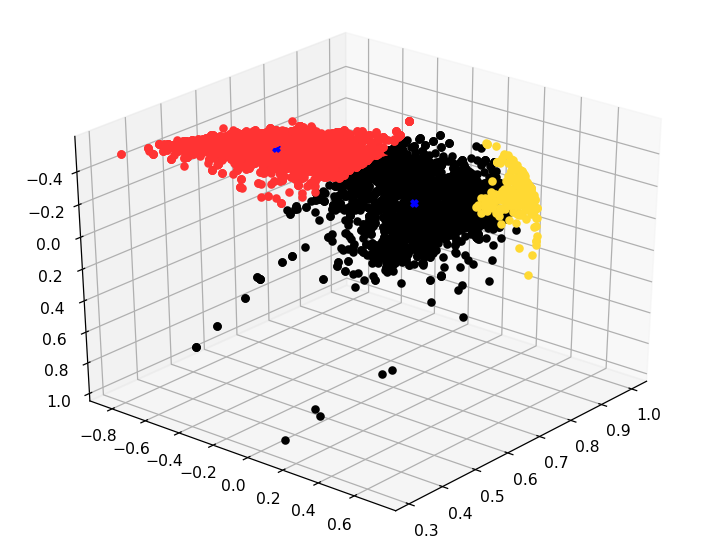

In [27]:
K = 3
alpha = grey_wolf_optimization()
print("DB Index        :"+str(davies_bouldin_index(alpha)))
print("Silhoutte Index :"+str(silhoutette_index(alpha)))
print("Calinski-Harabasz Index :"+str(calinski_harabasz(alpha)))
plot(alpha)

Generation 1: 49.84473906925426
Generation 2: 49.76755636973926
Generation 3: 49.57833323988644
Generation 4: 49.45551168708719
Generation 5: 49.0666396376637
Generation 6: 49.52935549071508
Generation 7: 49.45205034574692
Generation 8: 49.23421765481158
Generation 9: 49.008911189974214
Generation 10: 48.80956202480491
Generation 11: 48.813770943920176
Generation 12: 48.80859918852198
Generation 13: 48.81750924448984
Generation 14: 48.817509244489834
Generation 15: 48.8716416850317
Generation 16: 48.930237326336346
Generation 17: 48.817509244489834
Generation 18: 48.817509244489834
Generation 19: 48.81750924448984
Stopping GWO because same results over past 2 generations
Time taken: 118.8125
DB Index        :0.7933187549830097
Silhoutte Index :0.875561423908302
Calinski-Harabasz Index :58180.211555338756
751
223
929
1701
2109


<IPython.core.display.Javascript object>


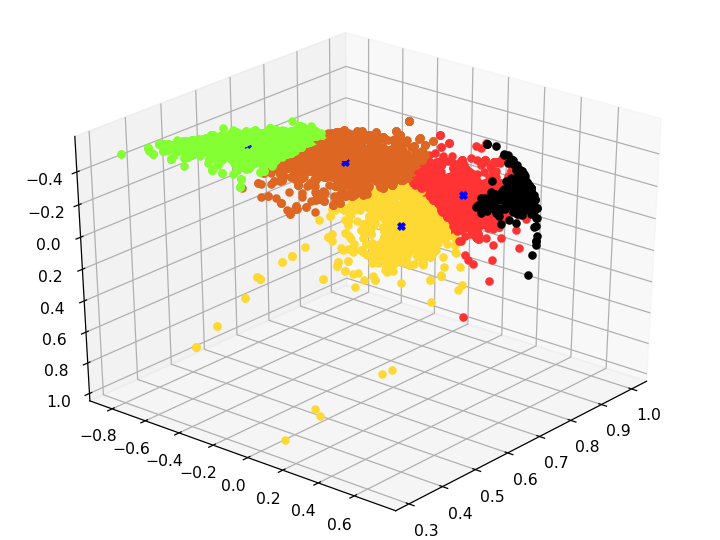

In [21]:
K = 5
alpha = grey_wolf_optimization()
print("DB Index        :"+str(davies_bouldin_index(alpha)))
print("Silhoutte Index :"+str(silhoutette_index(alpha)))
print("Calinski-Harabasz Index :"+str(calinski_harabasz(alpha)))
plot(alpha)

Generation 1: 99.15160939037136
Generation 2: 98.92424791786003
Generation 3: 98.81062591881417
Generation 4: 98.06531781279021
Generation 5: 96.89983531868654
Generation 6: 96.80043490772309
Generation 7: 97.1129471851285
Generation 8: 97.01510779555007
Generation 9: 97.17757443437428
Generation 10: 96.57328589601157
Generation 11: 96.58485008392108
Generation 12: 97.23531223346828
Generation 13: 97.25949687509397
Generation 14: 97.07530375932367
Generation 15: 97.14645135499157
Generation 16: 97.29383108599288
Generation 17: 97.34135359042601
Generation 18: 97.34218195629055
Generation 19: 97.62331387301536
Generation 20: 97.52943580508958
Generation 21: 97.24567934909139
Generation 22: 97.24567934909139
Generation 23: 97.24567934909139
Stopping GWO because same results over past 2 generations
Time taken: 172.71875
DB Index        :0.8521564631212981
Silhoutte Index :0.9350722109188427
Calinski-Harabasz Index :52827.72681950984
516
638
220
761
661
1291
1626


<IPython.core.display.Javascript object>


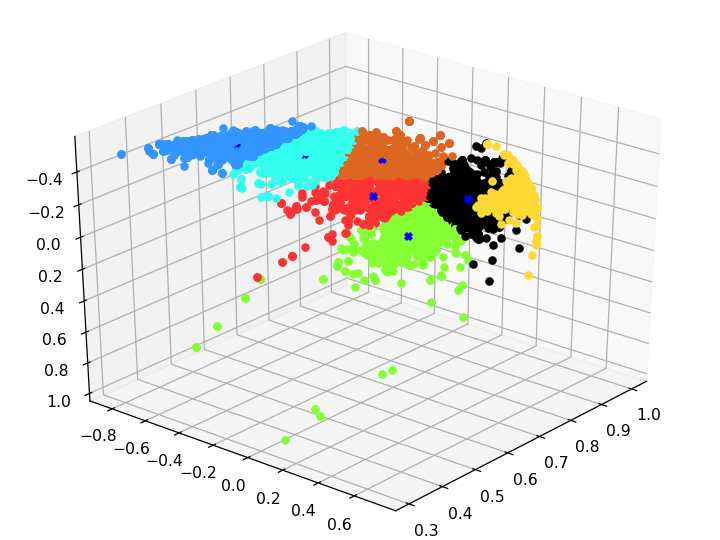

In [22]:
K = 7
alpha = grey_wolf_optimization()
print("DB Index        :"+str(davies_bouldin_index(alpha)))
print("Silhoutte Index :"+str(silhoutette_index(alpha)))
print("Calinski-Harabasz Index :"+str(calinski_harabasz(alpha)))
plot(alpha)

Generation 1: 167.85929624256053
Generation 2: 165.64761818614315
Generation 3: 165.16356394687958
Generation 4: 164.8581502164848
Generation 5: 164.79261024774078
Generation 6: 165.59696683382631
Generation 7: 164.7707329130018
Generation 8: 164.1367438542121
Generation 9: 164.76454677612327
Generation 10: 164.24856472193892
Generation 11: 164.9320242508279
Generation 12: 164.59453529263413
Generation 13: 164.82296212774966
Generation 14: 164.3872777262815
Generation 15: 163.5505934603848
Generation 16: 163.6992761299516
Generation 17: 162.90432412231496
Generation 18: 163.03725894646584
Generation 19: 163.47263912009007
Generation 20: 163.14057157987872
Generation 21: 163.68647866899704
Generation 22: 163.4852858989775
Generation 23: 163.5237748007667
Generation 24: 162.95661623503906
Generation 25: 163.3788163388784
Generation 26: 163.40964551156154
Generation 27: 163.17411729010377
Generation 28: 164.3626972794442
Generation 29: 163.2757000691884
Generation 30: 163.3087024654363
Ge

<IPython.core.display.Javascript object>


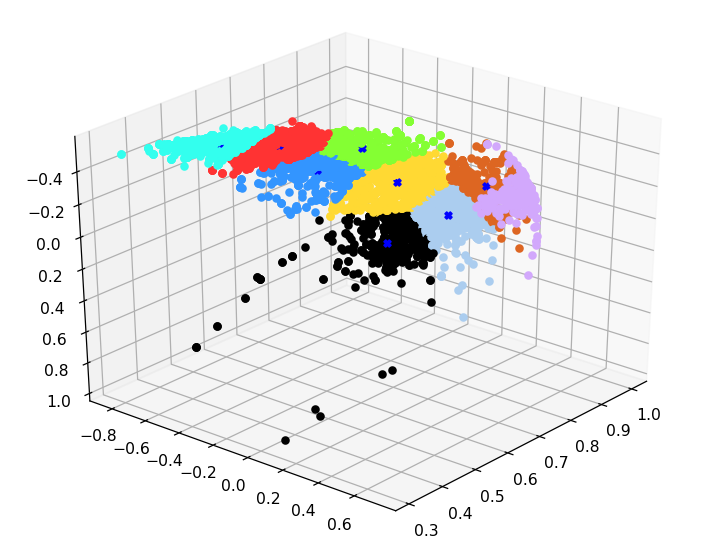

In [23]:
K = 9
alpha = grey_wolf_optimization()
print("DB Index        :"+str(davies_bouldin_index(alpha)))
print("Silhoutte Index :"+str(silhoutette_index(alpha)))
print("Calinski-Harabasz Index :"+str(calinski_harabasz(alpha)))
plot(alpha)